<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content-dl/blob/w2d4_updates/tutorials/W2D4_GenerativeModels/W2D4_Tutorial3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 3: Image, Conditional Diffusion and Beyond

**Week 2, Day 4: Name of the day**

**By Neuromatch Academy**

__Content creators:__ Binxu Wang

__Content reviewers:__ Shaonan Wang, Dongrui Deng, Dora Zhiyu Yang, Adrita Das

__Content editors:__ Shaonan Wang

__Production editors:__ Spiros Chavlis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

* Understand the idea behind Diffusion generative models: score and reversal of diffusion process.
* Learn the score function by denoising data.
* Hands-on experience in learning the score to generate certain distributions.

In [1]:
# @title Tutorial slides

# @markdown These are the slides for the videos in all tutorials today
from IPython.display import IFrame
link_id = "j89qg"
print(f"If you want to download the slides: https://osf.io/download/{link_id}/")
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

If you want to download the slides: https://osf.io/download/j89qg/


---
# Setup

In [2]:
# @title Install dependencies

# @markdown **WARNING**: There may be *errors* and/or *warnings* reported during the installation. However, they are to be ignored.

!pip install pillow --quiet  # always use quiet
!pip install diffusers transformers tokenizers --quiet
!pip install accelerate --quiet
!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "public_testbed",
            "user_key": "3zg0t05r",
        },
    ).render()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 116.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.0 MB/s eta 0:00:00


In [3]:
# Imports
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools

from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from tqdm.notebook import trange, tqdm
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR
from torchvision.utils import make_grid

In [4]:
# @title Figure settings
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [7]:
DEVICE = set_device()
SEED = 2021
set_seed(seed=SEED)

GPU is enabled in this notebook.
Random seed 2021 has been set.


We just learned the basic principles of diffusion models, with the takeaway that the score function allows us to turn pure noise into some interesting data distribution. Further, we will approximate the score function with a neural network via denoising score matching. But when working with images, we need our neural network to 'play nice' with them and to reflect the inductive biases we associate with images.

A reasonable choice is to choose the neural network architecture to be that of a **[U-Net](https://en.wikipedia.org/wiki/U-Net)**, which is a CNN-like architecture with:

* downscaling/upscaling operations that help the network process features of images at different spatial scales.
* skip connection as an information highway.

Since the score function we're trying to learn a function of time, we also need to devise a way to ensure our neural network properly responds to changes in time. For this purpose, we can use a **time embedding**.

In [8]:
# @title Video 1: Network architecture
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'Wih8AGPoZqo'),] # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [9]:
# @title Submit your feedback
content_review("W2D4_Network_Architecture")

## Coding Exercise 1: Train Diffusion for MNIST

Finally, let's implement and train an actual image diffusion model for the MNIST dataset.

By examining the neural network architecture of the score approximator, you will understand the inductive biases we built in.

In the next cell, you will implement the helper functions for the forward process.
* `marginal_prob_std` for $\sigma_t$ (note, it's standard deviation, not the variance)
* `diffusion_coeff` for $g(t)$

**Math Recap for Forward Processes**:

We will use the same forward process (variance exploding SDE) as in the last tutorial, which reads:

\begin{equation}
d\mathbf x=g(t)d\mathbf w
\end{equation}

and we let the diffusion coefficient $g(t)=\lambda^t$, with $\lambda > 1$.

If so, the marginal distribution of state  $\mathbf x_t$ at time t given an initial state $\mathbf x_0$ will be a Gaussian $\mathcal N(\mathbf x_t|\mathbf x_0,\sigma_t^2 I)$. The variance is the integration of the squared diffusion coefficient.

\begin{equation}
\sigma_t^2 =\int_0^tg(\tau)^2d\tau=\frac{\lambda^{2t}-1}{2\log\lambda}
\end{equation}

In [10]:
def marginal_prob_std(t, Lambda, device='cpu'):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    std : The standard deviation.
  """
  t = t.to(device)
  #################################################
  ## TODO for students: Implement the standard deviation
  raise NotImplementedError("Student exercise: Implement the standard deviation")
  #################################################
  std = ...
  return std


def diffusion_coeff(t, Lambda, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    diff_coeff : The vector of diffusion coefficients.
  """
  #################################################
  ## TODO for students: Implement the diffusion coefficients
  raise NotImplementedError("Student exercise: Implement the diffusion coefficients")
  #################################################
  diff_coeff = ...
  return diff_coeff.to(device)

In [11]:
# to_remove solution
def marginal_prob_std(t, Lambda, device='cpu'):
  """Compute the standard deviation of $p_{0t}(x(t) | x(0))$.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    std : The standard deviation.
  """
  t = t.to(device)
  std = torch.sqrt((Lambda**(2 * t) - 1.) / 2. / np.log(Lambda))
  return std


def diffusion_coeff(t, Lambda, device='cpu'):
  """Compute the diffusion coefficient of our SDE.

  Args:
    t: A vector of time steps.
    Lambda: The $\lambda$ in our SDE.

  Returns:
    diff_coeff : The vector of diffusion coefficients.
  """
  diff_coeff = Lambda**t
  return diff_coeff.to(device)

### Network architecture

Below is code for a simple time embedding and modulation layer. Basically, time $t$ is multiplexed as sine and cosine basis, then a linear readout creates the time modulation signal.

In [12]:
# @title Time embedding and modulation

class GaussianFourierProjection(nn.Module):
  """Gaussian random features for encoding time steps."""
  def __init__(self, embed_dim, scale=30.):
    super().__init__()
    # Randomly sample weights (frequencies) during initialization.
    # These weights (frequencies) are fixed during optimization and are not trainable.
    self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
  def forward(self, x):
    # Cosine(2 pi freq x), Sine(2 pi freq x)
    x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class Dense(nn.Module):
  """A fully connected layer that reshapes outputs to feature maps.
  Allow time repr to input additively from the side of a convolution layer.
  """
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.dense = nn.Linear(input_dim, output_dim)
  def forward(self, x):
    # this broadcast the 2d tensor to 4d, add the same value across space.
    return self.dense(x)[..., None, None]

Below is code for a simple U-Net architecture. Apparently, diffusion models can be more or less successful with different architectural details. So this example is mainly for illustrative purposes.

In [13]:
# @title Time-dependent UNet score model

class UNet(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings.
    """
    super().__init__()
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
          GaussianFourierProjection(embed_dim=embed_dim),
          nn.Linear(embed_dim, embed_dim)
          )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.t_mod1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.t_mod2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.t_mod3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.t_mod4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])


    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.t_mod5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
    self.tconv3 = nn.ConvTranspose2d(channels[2] + channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
    self.t_mod6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
    self.tconv2 = nn.ConvTranspose2d(channels[1] + channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
    self.t_mod7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0] + channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = lambda x: x * torch.sigmoid(x)
    # A restricted version of the `marginal_prob_std` function, after specifying a Lambda.
    self.marginal_prob_std = marginal_prob_std

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    # Encoding path, downsampling
    ## Incorporate information from t
    h1 = self.conv1(x)  + self.t_mod1(embed)
    ## Group normalization  and  apply activation function
    h1 = self.act(self.gnorm1(h1))
    #  2nd conv
    h2 = self.conv2(h1) + self.t_mod2(embed)
    h2 = self.act(self.gnorm2(h2))
    # 3rd conv
    h3 = self.conv3(h2) + self.t_mod3(embed)
    h3 = self.act(self.gnorm3(h3))
    # 4th conv
    h4 = self.conv4(h3) + self.t_mod4(embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path up sampling
    h = self.tconv4(h4) + self.t_mod5(embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(torch.cat([h, h2], dim=1)) + self.t_mod7(embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(torch.cat([h, h1], dim=1))

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

### Think! 1: U-Net Architecture

Looking at the U-Net architecture, can you find the module(s) corresponding to the following operations?
1. Downsampling the spatial features?
2. Upsampling the spatial features?
3. The skip connection from the down branch to the up branch, how is it implemented?
5. How is time modulation implemented?
5. Why is the output divided by `self.marginal_prob_std(t)` before output? How might this help or harm the score learning?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).

In [14]:
# to_remove explanation

"""
Discussion:

1. Downsampling is implemented as stride in Conv2d
2. Upsampling is implemented as stride in ConvTranspose2d
3. Skip connection is by concatenation e.g.
  `self.tconv3(torch.cat([h, h3], dim=1))`
4. By adding the output of `t_mod` layers e.g.
  `h = self.tconv3(torch.cat([h, h3], dim=1)) + self.t_mod6(embed)`
5. Inspective the objective we can see the target for $s(x,t) is z/\sigma_t$.
*Pro*: If we divide the noise scale $\sigma_t$, within the network, then the neural network only need to model
the target $z$ which has the same variance ~ 1 across time $t$.

*Con*: Note this will amplify the noise and signal by a lot when t ~ 0 .
So it will have large error for low noise conditions.
The weighting function is kind of counteracting this effect,
i.e. lowering the weights of small $\sigma_t$ period in the overall loss.
""";

In [15]:
# @title Submit your feedback
content_review("W2D4_UNet_Architecture")

### Defining the loss function

In the next cell, you will implement the denoising score matching (DSM) objective as we used in the last tutorial.

\begin{equation}
\mathcal L=\int_\epsilon^1dt \mathbb E_{x\sim p_0(x)}\mathbb E_{z\sim \mathcal N(0,I)}\|\sigma_t s_\theta(x+\sigma_t z, t)+z\|^2
\end{equation}

where the time weighting is chosen as $\gamma_t=\sigma_t^2$, which emphasizes the high noise period ($t\sim 1$) more than the low noise period ($t\sim 0$).

**Tips**:

* The major difference from the last tutorial is that the score $s$, noise $z$, and states $x$ are all batch image-shaped tensor, so remember to broadcast the $\sigma_t$ properly. e.g. this `std[:, None, None, None]` will be helpful.
* `eps` is set at a small number to stop the model from learning the score function of a very small noise scale, which is highly irregular.


In [16]:
def loss_fn(model, x, marginal_prob_std, eps=1e-3, device='cpu'):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      Note, it takes two inputs in its forward function model(x, t)
      $s_\theta(x,t)$ in the equation
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel, takes `t` as input.
      $\sigma_t$ in the equation.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in eps, 1
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t).to(device)
  #################################################
  ## TODO for students: Implement the denoising score matching eq.
  raise NotImplementedError("Student exercise: Implement the denoising score matching eq. ")
  #################################################
  # get normally distributed noise N(0, I)
  z = ...
  # compute the perturbed x = x + z * \sigma_t
  perturbed_x = ...
  # predict score with the model at (perturbed x, t)
  score = ...
  # compute distance between the score and noise \| score * sigma_t + z \|_2^2
  loss = ...
  ##############
  return loss

In [17]:
# to_remove solution
def loss_fn(model, x, marginal_prob_std, eps=1e-3, device='cpu'):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
      Note, it takes two inputs in its forward function model(x, t)
      $s_\theta(x,t)$ in the equation
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel, takes `t` as input.
      $\sigma_t$ in the equation.
    eps: A tolerance value for numerical stability.
  """
  # Sample time uniformly in eps, 1
  random_t = torch.rand(x.shape[0], device=device) * (1. - eps) + eps
  # Find the noise std at the time `t`
  std = marginal_prob_std(random_t).to(device)
  # get normally distributed noise N(0, I)
  z = torch.randn_like(x).to(device)
  # compute the perturbed x = x + z * \sigma_t
  perturbed_x = x + z * std[:, None, None, None]
  # predict score with the model at (perturbed x, t)
  score = model(perturbed_x, random_t)
  # compute distance between the score and noise \| score * sigma_t + z \|_2^2
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
  ##############
  return loss

A correctly implemented loss function shall pass the test below.

For a dataset with a single `0` datapoint, we have the analytical score $\mathbf s(\mathbf x,t)=-\mathbf x/\sigma_t^2$. We test that, for this case, the analytical has zero loss.

In [18]:
# @title Test loss function
marginal_prob_std_test = lambda t: marginal_prob_std(t, Lambda=10, device='cpu')
score_analyt_test = lambda x_t, t: - x_t / marginal_prob_std_test(t)[:,None,None,None]**2
x_test = torch.zeros(10, 3, 64, 64)
loss = loss_fn(score_analyt_test, x_test, marginal_prob_std_test, eps=1e-3, device='cpu')
assert torch.allclose(loss,torch.zeros(1)), "the loss should be zero in this case"

### Train and Test the Diffusion Model

**Note:** We have reduced the `n_epochs` to 12, but feel free to increase and use a larger value. The original value was set to 100, but if the training takes too long, `n_epochs=50` with `batch_size=1024` also suffice. An average loss of around ~30 can generate acceptable digits.

In [19]:
# @title Training the model
Lambda = 25.0  # @param {'type':'number'}

marginal_prob_std_fn = lambda t: marginal_prob_std(t, Lambda=Lambda, device=DEVICE)
diffusion_coeff_fn = lambda t: diffusion_coeff(t, Lambda=Lambda, device=DEVICE)
score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
score_model = score_model.to(DEVICE)

n_epochs = 12  # @param {'type':'integer'}
# size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
# learning rate
lr = 10e-4  # @param {'type':'number'}

set_seed(SEED)
dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
g = torch.Generator()
g.manual_seed(SEED)
data_loader = DataLoader(dataset, batch_size=batch_size,
                         shuffle=True, num_workers=2,
                         worker_init_fn=seed_worker,
                         generator=g,)

optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 1 - epoch / n_epochs))
tqdm_epoch = trange(n_epochs)

for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  pbar = tqdm(data_loader)
  for x, y in pbar:
    x = x.to(DEVICE)
    loss = loss_fn(score_model, x, marginal_prob_std_fn, eps=0.01, device=DEVICE)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  print(f"Average Loss: {(avg_loss / num_items):5f} lr {scheduler.get_last_lr()[0]:.1e}")
  # Print the averaged training loss so far.
  tqdm_epoch.set_description(f'Average Loss: {(avg_loss / num_items):.5f}')
  # Update the checkpoint after each epoch of training.
  torch.save(score_model.state_dict(), 'ckpt.pth')

Random seed 2021 has been set.


100%|██████████| 9912422/9912422 [00:00<00:00, 92773728.01it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 113105222.99it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 24910102.50it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21214397.29it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 897.445934 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 241.083123 lr 8.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 157.682528 lr 7.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 120.428461 lr 6.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 100.288831 lr 5.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 86.939096 lr 5.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 77.987022 lr 4.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 71.856398 lr 3.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 67.022057 lr 2.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 64.278006 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 61.467362 lr 2.0e-04


  0%|          | 0/59 [00:00<?, ?it/s]

Average Loss: 59.688240 lr 2.0e-04


In [20]:
# @title Define the Sampler
def Euler_Maruyama_sampler(score_model,
              marginal_prob_std,
              diffusion_coeff,
              batch_size=64,
              x_shape=(1, 28, 28),
              num_steps=500,
              device='cuda',
              eps=1e-3, y=None):
  """Generate samples from score-based models with the Euler-Maruyama solver.

  Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
      Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

  Returns:
    Samples.
  """
  t = torch.ones(batch_size).to(device)
  r = torch.randn(batch_size, *x_shape).to(device)
  init_x = r * marginal_prob_std(t)[:, None, None, None]
  init_x = init_x.to(device)
  time_steps = torch.linspace(1., eps, num_steps).to(device)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  with torch.no_grad():
    for time_step in tqdm(time_steps):
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      g = diffusion_coeff(batch_time_step)
      mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
      x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)
  # Do not include any noise in the last sampling step.
  return mean_x

  0%|          | 0/250 [00:00<?, ?it/s]

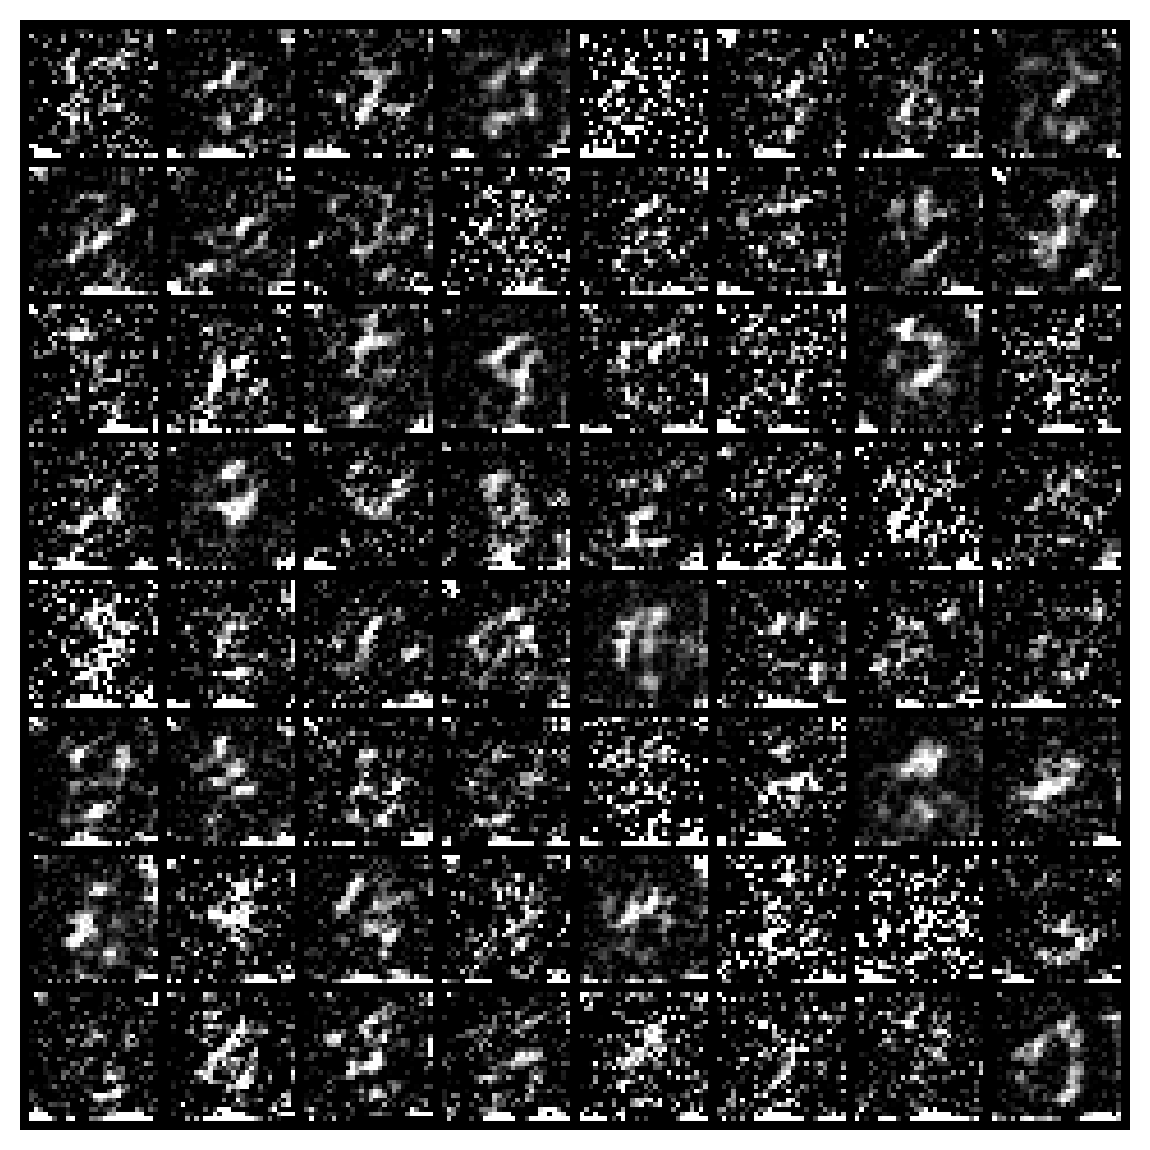

In [21]:
# @title Sampling
def save_samples_uncond(score_model, suffix="", device='cpu'):
  score_model.eval()
  ## Generate samples using the specified sampler.
  sample_batch_size = 64  # @param {'type':'integer'}
  num_steps = 250  # @param {'type':'integer'}
  # score_model.eval()
  ## Generate samples using the specified sampler.
  samples = Euler_Maruyama_sampler(score_model,
                                   marginal_prob_std_fn,
                                   diffusion_coeff_fn,
                                   sample_batch_size,
                                   num_steps=num_steps,
                                   device=DEVICE,
                                   eps=0.001)

  # Sample visualization.
  samples = samples.clamp(0.0, 1.0)
  sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))
  sample_np = sample_grid.permute(1, 2, 0).cpu().numpy()
  plt.imsave(f"uncondition_diffusion{suffix}.png", sample_np, )
  plt.figure(figsize=(6,6))
  plt.axis('off')
  plt.imshow(sample_np, vmin=0., vmax=1.)
  plt.show()


marginal_prob_std_fn = lambda t: marginal_prob_std(t, Lambda=Lambda, device=DEVICE)
uncond_score_model = UNet(marginal_prob_std=marginal_prob_std_fn)
uncond_score_model.load_state_dict(torch.load("ckpt.pth"))
uncond_score_model.to(DEVICE)
save_samples_uncond(uncond_score_model, suffix="", device=DEVICE)

Nice job! You have just finished the training of a Diffusion model. As you see, the result is not ideal, and many factors affect this. To name a few:

* **Better network architecture**: residual connections, attention mechanism, better upsampling mechanism
* **Better objective**: better weighting function $\gamma_t$
* **Better optimization procedure**: using learning rate decay
* **Better sampling algorithm**: Euler integration is known to have larger errors, so it's advisable to use a more advanced SDE or ODE solver

In [22]:
# @title Submit your feedback
content_review("W2D4_Sampling")

---
# Section 2: Conditional Diffusion Model

Another way to greatly improve the result is adding a conditional signal -- for example, tell the score network which digit you want. This makes the score modeling much more effortless and adds controllability to the user. The popular Stable Diffusion model is one of this kind, which uses natural language text as the conditional signal for images.

In [23]:
# @title Video 2: Conditional Diffusion Model
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'kuIOVWAUohI')]  # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In formulation, the conditional diffusion is highly similar to the unconditional diffusion.

In [24]:
# @title Submit your feedback
content_review("W2D4_Conditional_Diffusion_Model")

If you are curious about how to build and train a conditional diffusion model, you are welcome to look at the Bonus exercise at the end.

---
## Interactive Demo 2: Stable Diffusion

In this demo, we will play with one of the most potent open-source diffusion models, Stable Diffusion 2.1, and try to connect with what we have learned.

In [25]:
# @title Video 3: Advanced Techinque - Stable Diffusion
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0ZVXyRpScP8')]  # ('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [26]:
# @title Submit your feedback
content_review("W2D4_Advanced Techinque - Stable Diffusion")

In [27]:
#@title Download the Stable Diffusion models
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, PNDMScheduler

model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
# Use the PNDM scheduler as default
# pipe.scheduler = PNDMScheduler.from_config(pipe.scheduler.config)
# Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to(DEVICE)

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Now you can let loose your imagination and create artworks from text!

Example prompts:

```python
prompt = "A lovely cat running on the dessert in Van Gogh style, trending art."
prompt = "A ballerina dancing under the starry night in Monet style, trending art."
```

  0%|          | 0/50 [00:00<?, ?it/s]

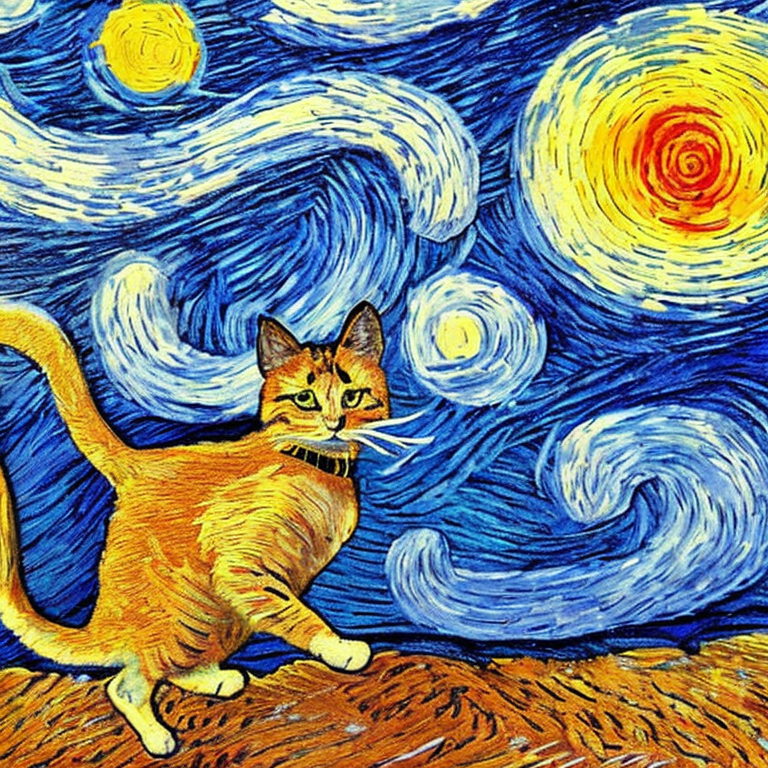

In [28]:
prompt = "A lovely cat running on the dessert in Van Gogh style, trending art." # @param {'type':'string'}
my_seed = 2023  # @param {'type':'integer'}
image = pipe(prompt, num_inference_steps=50,
             generator=torch.Generator("cuda").manual_seed(my_seed)).images[0]
image

In [29]:
# @title Helper function to inspect network
def recursive_print(module, prefix="", depth=0, deepest=3):
  """Simulating print(module) for torch.nn.Modules
      but with depth control. Print to the `deepest` level. `deepest=0` means no print
  """
  if depth == 0:
    print(f"[{type(module).__name__}]")
  if depth >= deepest:
    return
  for name, child in module.named_children():
    if len([*child.named_children()]) == 0:
      print(f"{prefix}({name}): {child}")
    else:
      if isinstance(child, nn.ModuleList):
        print(f"{prefix}({name}): {type(child).__name__} len={len(child)}")
      else:
        print(f"{prefix}({name}): {type(child).__name__}")
    recursive_print(child, prefix=prefix + "  ", depth=depth + 1, deepest=deepest)

## Think! 2 Architecture of Stable Diffusion Model

Can you see the similarity between the U-Net in Stable Diffusion and the baby UNet we defined up there?
To inspect the architecture, you can use the `recursive_print(pipe.unet,deepest=2)` function with a different `deepest`.

The text is encoded through the CLIP model, and you can also look at its structure below `recursive_print(pipe.text_encoder,deepest=4)`, which is a large transformer!

Take 2 minutes to think and play with the code, then discuss as a group (~10 minutes).

In [30]:
recursive_print(pipe.unet,deepest=2)

[UNet2DConditionModel]
(conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
(time_proj): Timesteps()
(time_embedding): TimestepEmbedding
  (linear_1): Linear(in_features=320, out_features=1280, bias=True)
  (act): SiLU()
  (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
(down_blocks): ModuleList len=4
  (0): CrossAttnDownBlock2D
  (1): CrossAttnDownBlock2D
  (2): CrossAttnDownBlock2D
  (3): DownBlock2D
(up_blocks): ModuleList len=4
  (0): UpBlock2D
  (1): CrossAttnUpBlock2D
  (2): CrossAttnUpBlock2D
  (3): CrossAttnUpBlock2D
(mid_block): UNetMidBlock2DCrossAttn
  (attentions): ModuleList len=1
  (resnets): ModuleList len=2
(conv_norm_out): GroupNorm(32, 320, eps=1e-05, affine=True)
(conv_act): SiLU()
(conv_out): Conv2d(320, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


In [31]:
recursive_print(pipe.text_encoder,deepest=4)

[CLIPTextModel]
(text_model): CLIPTextTransformer
  (embeddings): CLIPTextEmbeddings
    (token_embedding): Embedding(49408, 1024)
    (position_embedding): Embedding(77, 1024)
  (encoder): CLIPEncoder
    (layers): ModuleList len=23
      (0): CLIPEncoderLayer
      (1): CLIPEncoderLayer
      (2): CLIPEncoderLayer
      (3): CLIPEncoderLayer
      (4): CLIPEncoderLayer
      (5): CLIPEncoderLayer
      (6): CLIPEncoderLayer
      (7): CLIPEncoderLayer
      (8): CLIPEncoderLayer
      (9): CLIPEncoderLayer
      (10): CLIPEncoderLayer
      (11): CLIPEncoderLayer
      (12): CLIPEncoderLayer
      (13): CLIPEncoderLayer
      (14): CLIPEncoderLayer
      (15): CLIPEncoderLayer
      (16): CLIPEncoderLayer
      (17): CLIPEncoderLayer
      (18): CLIPEncoderLayer
      (19): CLIPEncoderLayer
      (20): CLIPEncoderLayer
      (21): CLIPEncoderLayer
      (22): CLIPEncoderLayer
  (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)


In [32]:
# to_remove explanation

"""
In Stable Diffusion, the (time_proj) and (time_embedding) layers resemble the GaussianFourierProjection layers we used in the last coding exercise, both multiplex time t and fed them into a neural network to modulate the convolutional layers per channel.
(down_blocks) resembles the down sampling convolution layers from conv1 to conv4 .
(up_blocks) resembles the up sampling and transpose convolution layers we from tconv4 to tconv1 .
text_model is a CLIP model that encodes text conditional signal into a bunch of word vectors.
CrossAttention in Stable Diffusion implements conditional modulation.
""";

In [33]:
# @title Submit your feedback
content_review("W2D4_UNet_vs_babyUNet")

---
# Section 3: Ethical Considerations



In [34]:
# @title Video 4: Ethical Consideration
from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', '0nJB0oBjokk')]  #('Bilibili', '<video_id_2>'), ('Osf', '<video_id_3>')]
tab_contents = display_videos(video_ids, W=854, H=480)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

In [35]:
# @title Submit your feedback
content_review("W2D4_Ethical_Consideration")

## Think! 3: Copyright of imagery generated from diffusion generated models

Suppose you prompt a pretrained diffusion model with the name of the artist and obtain beautiful imagery similar to that artist's style. Who has the copyright of the generated image? The producing company of the diffusion model, the original artist, you, the prompter, the random seed and the weights, or the GPU that runs the inference?

Who do you think deserves the credit and why?

What if you apply enough post-processing steps to the generated images, e.g., finetune the prompt and seed, or edit the image?

Take 2 minutes to think in silence, then discuss as a group (~10 minutes).


In [36]:
# to_remove explanation

"""
This is an open-ended question, and the answer to it will depend on how the legal
framework around AI-generated content develops. From the perspective of summer 2023,
here are some general principles to consider

  * The producing company of the diffusion model: If the AI model was created by
  a company, they may have some claim, so please refer to their documentation.
  For example, per OpenAI [1], you own what you create on DALLE.
  But for MidJourney [2], “non-paid users don’t own assets they create”,
  only paid users do.

  * The original artist: While the diffusion model might generate images reminiscent
  of a specific artist's style, the artist generally wouldn't hold copyright
  over the AI-generated content. They can't copyright a style, only specific works [3].
  However, if the output very closely resembles specific pieces of their work
  to the point of reproduction, this could potentially infringe on their copyright.

  * You, the prompter: As the user interacting with the AI, you might have a claim
  to the generated content, particularly if you've provided creative input to the
  process, such as customizing the prompt or editing the final result.
  This is akin to using a complex tool to create a work of art.

  * The random seed and the weights: Theoretically, neither the seed nor the
  weights can own the copyright since they are non-human entities. They are parts of
  the machine learning model and the algorithm that generates the output.

  * The GPU that runs the inference: Similarly, hardware cannot hold a copyright.
  The GPU is a tool used in the process, akin to a paintbrush or a camera in
  traditional art.

  * As for who deserves the credit, this is largely subjective and depends on the
  specifics of the situation. From a legal perspective, you—the individual who
  prompts the AI and shapes its output—might be considered the author of the work.
  But ethically speaking, it could be seen as a collaborative effort between you
  and the developers of the AI model, and maybe the artists who provide the
  training data.

Applying enough post-processing steps could strengthen your claim to copyright,
as it demonstrates additional creativity and input on your part.
Editing an image or fine-tuning a prompt increases your creative contribution
to the final piece.

References
[1]: https://help.openai.com/en/articles/6425277-can-i-sell-images-i-create-with-dall-e
[2]: https://docs.midjourney.com/docs/terms-of-service
[3]: https://www.thelegalartist.com/blog/you-cant-copyright-style
""";

In [37]:
# @title Submit your feedback
content_review("W2D4_copyright of SD image ")

---
# Summary

Today, we learned about

* One major application for diffusion modeling, i.e., Modeling natural images.
* Inductive biases suitable for image modeling: U-Net architecture and time modulation mechanism.
* Introduction to conditional diffusion models, with a demo on Stable Diffusion.
* Ethical considerations related to diffusion models, including copyright, misinformation, and fairness.

---
# Bonus Coding Exercies: Train Conditional Diffusion for MNIST

In this part, we'd like to train an MNIST generative model conditioned on the digit.

Here we will use a basic form of conditional modulation, i.e., digit embedding, to linearly control the relative gain of the features. After learning about the attention mechanism, you could think about better ways conditional modulation, e.g., using cross-attention to modulate the score model.

## UNet score model with conditional modulation

In [38]:
class UNet_Conditional(nn.Module):
  """A time-dependent score-based model built upon U-Net architecture."""

  def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
               text_dim=256, nClass=10):
    """Initialize a time-dependent score-based network.

    Args:
      marginal_prob_std: A function that takes time t and gives the standard
        deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
      channels: The number of channels for feature maps of each resolution.
      embed_dim: The dimensionality of Gaussian random feature embeddings of time.
      text_dim:  the embedding dimension of text / digits.
      nClass:    number of classes you want to model.
    """
    super().__init__()
    # random embedding for classes
    self.cond_embed = nn.Embedding(nClass, text_dim)
    # Gaussian random feature embedding layer for time
    self.time_embed = nn.Sequential(
        GaussianFourierProjection(embed_dim=embed_dim),
        nn.Linear(embed_dim, embed_dim)
        )
    # Encoding layers where the resolution decreases
    self.conv1 = nn.Conv2d(1, channels[0], 3, stride=1, bias=False)
    self.t_mod1 = Dense(embed_dim, channels[0])
    self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

    self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
    self.t_mod2 = Dense(embed_dim, channels[1])
    self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
    self.y_mod2 = Dense(embed_dim, channels[1])

    self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
    self.t_mod3 = Dense(embed_dim, channels[2])
    self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
    self.y_mod3 = Dense(embed_dim, channels[2])

    self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
    self.t_mod4 = Dense(embed_dim, channels[3])
    self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
    self.y_mod4 = Dense(embed_dim, channels[3])

    # Decoding layers where the resolution increases
    self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
    self.t_mod5 = Dense(embed_dim, channels[2])
    self.y_mod5 = Dense(embed_dim, channels[2])
    self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

    self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)     #  + channels[2]
    self.t_mod6 = Dense(embed_dim, channels[1])
    self.y_mod6 = Dense(embed_dim, channels[1])
    self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

    self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)     #  + channels[1]
    self.t_mod7 = Dense(embed_dim, channels[0])
    self.y_mod7 = Dense(embed_dim, channels[0])
    self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
    self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

    # The swish activation function
    self.act = nn.SiLU() # lambda x: x * torch.sigmoid(x)
    self.marginal_prob_std = marginal_prob_std
    for module in [self.y_mod2,self.y_mod3,self.y_mod4,
                   self.y_mod5,self.y_mod6,self.y_mod7]:
        nn.init.normal_(module.dense.weight, mean=0, std=0.0001)
        nn.init.constant_(module.dense.bias, 1.0)

  def forward(self, x, t, y=None):
    # Obtain the Gaussian random feature embedding for t
    embed = self.act(self.time_embed(t))
    y_embed = self.cond_embed(y)
    # Encoding path
    h1 = self.conv1(x) + self.t_mod1(embed)
    ## Incorporate information from t
    ## Group normalization
    h1 = self.act(self.gnorm1(h1))
    h2 = self.conv2(h1) + self.t_mod2(embed)
    h2 = h2 * self.y_mod2(y_embed)
    h2 = self.act(self.gnorm2(h2))
    h3 = self.conv3(h2) + self.t_mod3(embed)
    h3 = h3 * self.y_mod3(y_embed)
    h3 = self.act(self.gnorm3(h3))
    h4 = self.conv4(h3) + self.t_mod4(embed)
    h4 = h4 * self.y_mod4(y_embed)
    h4 = self.act(self.gnorm4(h4))

    # Decoding path
    h = self.tconv4(h4) + self.t_mod5(embed)
    h = h * self.y_mod5(y_embed)
    ## Skip connection from the encoding path
    h = self.act(self.tgnorm4(h))
    h = self.tconv3(h + h3) + self.t_mod6(embed)
    h = h * self.y_mod6(y_embed)
    h = self.act(self.tgnorm3(h))
    h = self.tconv2(h + h2) + self.t_mod7(embed)
    h = h * self.y_mod7(y_embed)
    h = self.act(self.tgnorm2(h))
    h = self.tconv1(h + h1)

    # Normalize output
    h = h / self.marginal_prob_std(t)[:, None, None, None]
    return h

## Loss for conditional diffusion

In [39]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-3):
  """The loss function for training score-based generative models.

  Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
  """
  random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
  z = torch.randn_like(x)
  std = marginal_prob_std(random_t)
  perturbed_x = x + z * std[:, None, None, None]
  score = model(perturbed_x, random_t, y=y)
  loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2,
                              dim=(1, 2, 3)))
  return loss

In [40]:
# @title Training conditional diffusion model
Lambda = 25  #@param {'type':'number'}
marginal_prob_std_fn = lambda t: marginal_prob_std(t, Lambda=Lambda, device=DEVICE)
diffusion_coeff_fn = lambda t: diffusion_coeff(t, Lambda=Lambda, device=DEVICE)
print("initilize new score model...")
score_model_cond = UNet_Conditional(marginal_prob_std=marginal_prob_std_fn)
score_model_cond = score_model_cond.to(DEVICE)

n_epochs = 10  # @param {'type':'integer'}
## size of a mini-batch
batch_size = 1024  # @param {'type':'integer'}
## learning rate
lr = 10e-4  # @param {'type':'number'}

dataset = MNIST('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

optimizer = Adam(score_model_cond.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.99 ** epoch))
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
  avg_loss = 0.
  num_items = 0
  for x, y in tqdm(data_loader):
    x = x.to(DEVICE)
    loss = loss_fn_cond(score_model_cond, x, y.to(DEVICE), marginal_prob_std_fn)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    avg_loss += loss.item() * x.shape[0]
    num_items += x.shape[0]
  scheduler.step()
  lr_current = scheduler.get_last_lr()[0]
  print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
  # Print the averaged training loss so far.
  tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
  # Update the checkpoint after each epoch of training.
  torch.save(score_model_cond.state_dict(), 'ckpt_cond.pth')

initilize new score model...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

0 Average Loss: 841.450891 lr 9.9e-04


  0%|          | 0/59 [00:00<?, ?it/s]

1 Average Loss: 229.710408 lr 9.8e-04


  0%|          | 0/59 [00:00<?, ?it/s]

2 Average Loss: 143.897346 lr 9.7e-04


  0%|          | 0/59 [00:00<?, ?it/s]

3 Average Loss: 107.492701 lr 9.6e-04


  0%|          | 0/59 [00:00<?, ?it/s]

4 Average Loss: 85.441500 lr 9.5e-04


  0%|          | 0/59 [00:00<?, ?it/s]

5 Average Loss: 72.234241 lr 9.4e-04


  0%|          | 0/59 [00:00<?, ?it/s]

6 Average Loss: 62.693105 lr 9.3e-04


  0%|          | 0/59 [00:00<?, ?it/s]

7 Average Loss: 55.667975 lr 9.2e-04


  0%|          | 0/59 [00:00<?, ?it/s]

8 Average Loss: 51.075156 lr 9.1e-04


  0%|          | 0/59 [00:00<?, ?it/s]

9 Average Loss: 47.374760 lr 9.0e-04


**Note:** The original value for `n_epochs` was 100.

  0%|          | 0/250 [00:00<?, ?it/s]

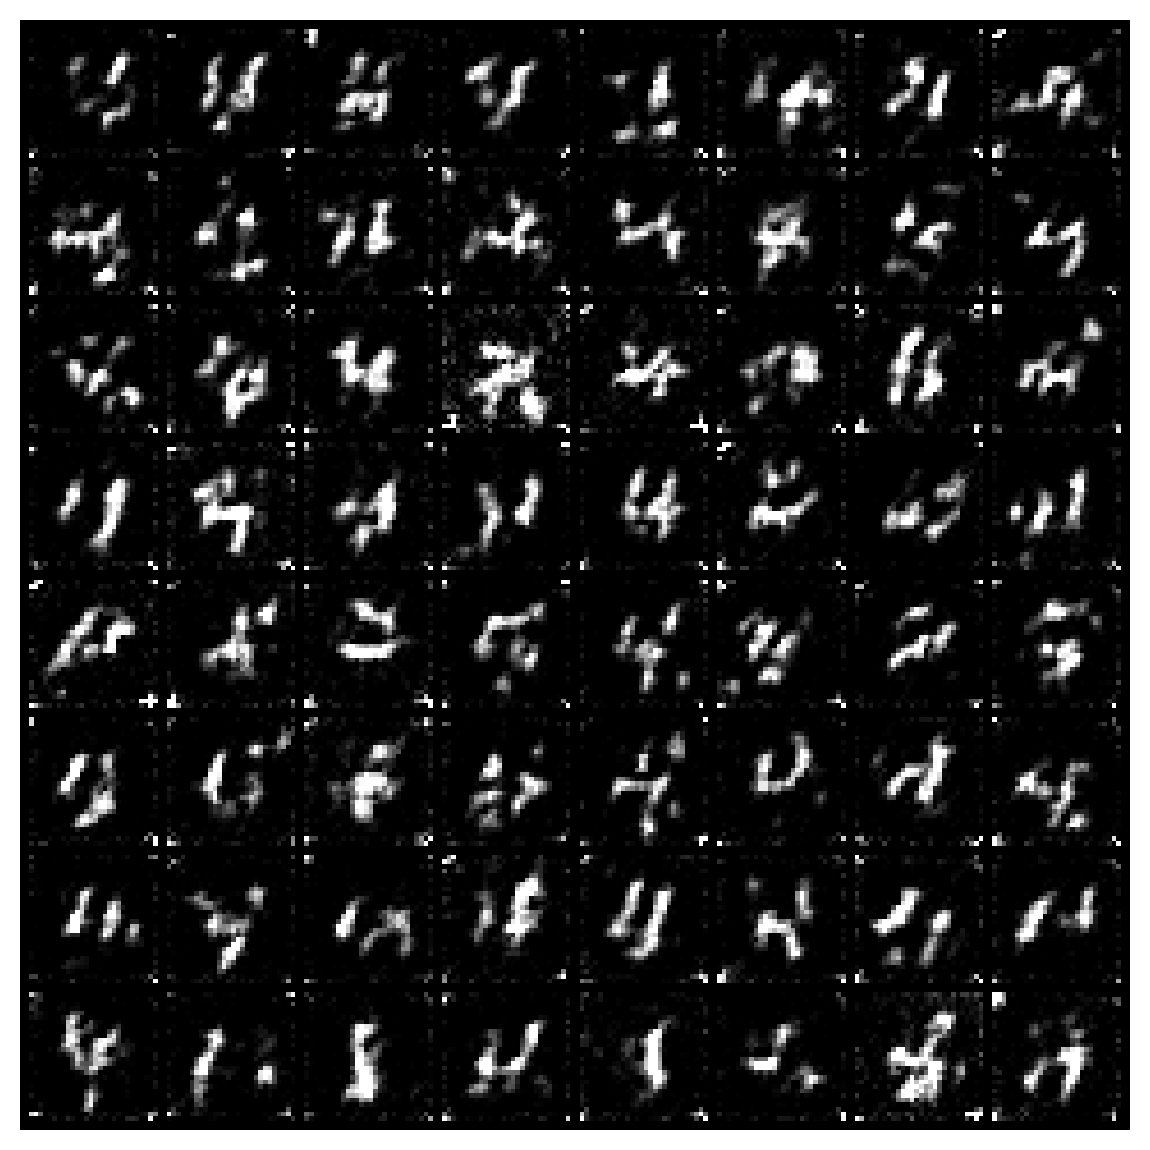

In [41]:
# @title Sample Conditional Diffusion
digit = 4  # @param {'type':'integer'}
sample_batch_size = 64  # @param {'type':'integer'}
num_steps = 250  # @param {'type':'integer'}
score_model_cond.eval()
## Generate samples using the specified sampler.
samples = Euler_Maruyama_sampler(
        score_model_cond,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=DEVICE,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long, device=DEVICE))

## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [42]:
torch.cuda.empty_cache()